In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import matplotlib.pyplot as plt

# dataset folder
source_folder = "solo_classification_REMI_dataset_unbalanced"
# where it saves the weights
destination_folder = "solo_classification_transformer_REMI_weights_unaugmented_200epochs"

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)
device = torch.device(dev)
print(device)

cuda:0
cuda:0


In [3]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=None, lower=True, include_lengths=True, batch_first=True)
fields = [('labels', label_field), ('notes', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=1)

In [4]:
ntokens = len(text_field.vocab)
emsize = 200
d_hid = 64
nlayers = 2 
nhead = 8
dropout = 0.6

In [5]:
for (labels, (notes, notes_len)), _ in (train_iter):
    print(notes)

tensor([[ 4,  7, 30,  ..., 24, 57,  5],
        [ 4,  7, 30,  ..., 15, 55, 96],
        [ 4,  7, 58,  ..., 65, 38,  2],
        ...,
        [ 4,  7, 58,  ...,  1,  1,  1],
        [ 4,  7, 58,  ...,  1,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1]], device='cuda:0')
tensor([[  4,   7,  30,  ...,  24,  27,   2],
        [  4,   7,  58,  ...,  23,   6,   1],
        [  4,   7,  30,  ...,  48, 172,   1],
        ...,
        [  4,   7,  58,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  58,  ...,   1,   1,   1]], device='cuda:0')
tensor([[  4,   7,  30,  ...,  12,  27,   6],
        [  4,   7,  30,  ...,  54,   6,   1],
        [  4,   7,  58,  ...,  71, 105,   1],
        ...,
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1]], device='cuda:0')
tensor([[ 4,  7, 58,  ..., 12, 52,  2],
        [ 4,  7, 58,  ...,  1,  1,  1],
        [ 4,  7, 58,  ...,  1,  1, 

In [6]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [7]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 2)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)
        output = self.decoder(output)
        output = torch.sigmoid(output)
        return output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [8]:
# Save and Load Functions https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [15]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total = 0
        total_correct = 0
        for (labels, (notes, notes_len)), _ in (train_loader):   
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())
            loss = criterion(output, labels.long())
            #loss = criterion(output.view(-1,1),labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            labels_max = labels.detach().cpu()
            output_max = np.argmax((output.detach().cpu()),axis=1)
            for i in range(len(labels_max)):
                total+=1
                if labels_max[i] ==  output_max[i]:
                    total_correct += 1
            accuracy = accuracy_score(labels_max, output_max)
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (notes, notes_len)), _ in (valid_loader):        
                        labels = labels.to(device)
                        notes = notes.to(device)
                        notes_len = notes_len.cpu()
                        output = model(notes.long())
                        loss = criterion(output, labels.long())
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print("Epoch Accuracy: {}".format(total_correct/total))
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)

train(model=model, optimizer=optimizer, num_epochs=200)

Epoch [1/200], Step [25/10000], Train Loss: 0.6819, Valid Loss: 0.6432
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch [1/200], Step [50/10000], Train Loss: 0.6520, Valid Loss: 0.6435
Epoch Accuracy: 0.6267427122940431
Epoch [2/200], Step [75/10000], Train Loss: 0.6349, Valid Loss: 0.6464
Epoch [2/200], Step [100/10000], Train Loss: 0.6565, Valid Loss: 0.6459
Epoch Accuracy: 0.6666666666666666
Epoch [3/200], Step [125/10000], Train Loss: 0.6349, Valid Loss: 0.6454
Epoch [3/200], Step [150/10000], Train Loss: 0.6418, Valid Loss: 0.6370
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch Accuracy: 0.6666666666666666
Epoch [4/200], Step [175/10000], Train Loss: 0.6493, Valid Loss: 0.6346
Model save

Epoch [25/200], Step [1250/10000], Train Loss: 0.4865, Valid Loss: 0.5101
Epoch Accuracy: 0.8301647655259823
Epoch [26/200], Step [1275/10000], Train Loss: 0.5063, Valid Loss: 0.5074
Epoch [26/200], Step [1300/10000], Train Loss: 0.4686, Valid Loss: 0.5087
Epoch Accuracy: 0.8377693282636248
Epoch [27/200], Step [1325/10000], Train Loss: 0.5007, Valid Loss: 0.5120
Epoch [27/200], Step [1350/10000], Train Loss: 0.4669, Valid Loss: 0.5083
Epoch Accuracy: 0.835234474017744
Epoch [28/200], Step [1375/10000], Train Loss: 0.4717, Valid Loss: 0.5127
Epoch [28/200], Step [1400/10000], Train Loss: 0.4950, Valid Loss: 0.5057
Epoch Accuracy: 0.8396704689480355
Epoch [29/200], Step [1425/10000], Train Loss: 0.4764, Valid Loss: 0.5091
Epoch [29/200], Step [1450/10000], Train Loss: 0.4884, Valid Loss: 0.5154
Epoch Accuracy: 0.8428390367553865
Epoch [30/200], Step [1475/10000], Train Loss: 0.5040, Valid Loss: 0.4951
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/

Epoch [62/200], Step [3075/10000], Train Loss: 0.4365, Valid Loss: 0.4770
Epoch [62/200], Step [3100/10000], Train Loss: 0.4507, Valid Loss: 0.4601
Epoch Accuracy: 0.8757921419518377
Epoch [63/200], Step [3125/10000], Train Loss: 0.4682, Valid Loss: 0.4630
Epoch [63/200], Step [3150/10000], Train Loss: 0.4181, Valid Loss: 0.4859
Epoch Accuracy: 0.8738910012674271
Epoch [64/200], Step [3175/10000], Train Loss: 0.4669, Valid Loss: 0.4492
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch [64/200], Step [3200/10000], Train Loss: 0.4277, Valid Loss: 0.4785
Epoch Accuracy: 0.8776932826362485
Epoch [65/200], Step [3225/10000], Train Loss: 0.4426, Valid Loss: 0.4591
Epoch [65/200], Step [3250/10000], Train Loss: 0.4298, Valid Loss: 0.4811
Epoch Accuracy: 0.8871989860583016
Epoch [66/200], Step [3275/10000], Train Loss: 0.4381, Valid Loss: 0.4623
Ep

Epoch [101/200], Step [5050/10000], Train Loss: 0.4090, Valid Loss: 0.4668
Epoch Accuracy: 0.9112801013941698
Epoch [102/200], Step [5075/10000], Train Loss: 0.4120, Valid Loss: 0.4431
Epoch [102/200], Step [5100/10000], Train Loss: 0.4090, Valid Loss: 0.4321
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch Accuracy: 0.9043092522179975
Epoch [103/200], Step [5125/10000], Train Loss: 0.4177, Valid Loss: 0.4493
Epoch [103/200], Step [5150/10000], Train Loss: 0.3986, Valid Loss: 0.4471
Epoch Accuracy: 0.9131812420785805
Epoch [104/200], Step [5175/10000], Train Loss: 0.4129, Valid Loss: 0.4354
Epoch [104/200], Step [5200/10000], Train Loss: 0.4070, Valid Loss: 0.4493
Epoch Accuracy: 0.908745247148289
Epoch [105/200], Step [5225/10000], Train Loss: 0.4116, Valid Loss: 0.4433
Epoch [105/200], Step [5250/10000], Train Loss: 0.3995, Valid Loss: 0

Epoch [142/200], Step [7075/10000], Train Loss: 0.3929, Valid Loss: 0.4459
Epoch [142/200], Step [7100/10000], Train Loss: 0.4033, Valid Loss: 0.4715
Epoch Accuracy: 0.9182509505703422
Epoch [143/200], Step [7125/10000], Train Loss: 0.3991, Valid Loss: 0.4636
Epoch [143/200], Step [7150/10000], Train Loss: 0.3923, Valid Loss: 0.4398
Epoch Accuracy: 0.926489226869455
Epoch [144/200], Step [7175/10000], Train Loss: 0.4022, Valid Loss: 0.4523
Epoch [144/200], Step [7200/10000], Train Loss: 0.3965, Valid Loss: 0.4563
Epoch Accuracy: 0.9182509505703422
Epoch [145/200], Step [7225/10000], Train Loss: 0.3915, Valid Loss: 0.4487
Epoch [145/200], Step [7250/10000], Train Loss: 0.4001, Valid Loss: 0.4608
Epoch Accuracy: 0.9239543726235742
Epoch [146/200], Step [7275/10000], Train Loss: 0.4050, Valid Loss: 0.4486
Epoch [146/200], Step [7300/10000], Train Loss: 0.3880, Valid Loss: 0.4540
Epoch Accuracy: 0.9239543726235742
Epoch [147/200], Step [7325/10000], Train Loss: 0.3807, Valid Loss: 0.4591
E

Epoch [186/200], Step [9300/10000], Train Loss: 0.3901, Valid Loss: 0.4470
Epoch Accuracy: 0.9296577946768061
Epoch [187/200], Step [9325/10000], Train Loss: 0.3850, Valid Loss: 0.4677
Epoch [187/200], Step [9350/10000], Train Loss: 0.3981, Valid Loss: 0.4659
Epoch Accuracy: 0.9226869455006337
Epoch [188/200], Step [9375/10000], Train Loss: 0.3919, Valid Loss: 0.4725
Epoch [188/200], Step [9400/10000], Train Loss: 0.3896, Valid Loss: 0.4649
Epoch Accuracy: 0.926489226869455
Epoch [189/200], Step [9425/10000], Train Loss: 0.3953, Valid Loss: 0.4569
Epoch [189/200], Step [9450/10000], Train Loss: 0.3840, Valid Loss: 0.4629
Epoch Accuracy: 0.926489226869455
Epoch [190/200], Step [9475/10000], Train Loss: 0.3814, Valid Loss: 0.4677
Epoch [190/200], Step [9500/10000], Train Loss: 0.4000, Valid Loss: 0.4494
Epoch Accuracy: 0.926489226869455
Epoch [191/200], Step [9525/10000], Train Loss: 0.3845, Valid Loss: 0.4626
Epoch [191/200], Step [9550/10000], Train Loss: 0.3962, Valid Loss: 0.4662
Epo

In [10]:
# torch.backends.cudnn.enabled = False

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt


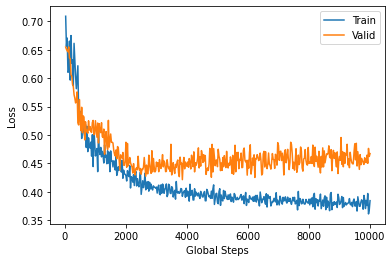

In [11]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()

plt.savefig("Transformer 200 epochs.png")
plt.show() 

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8087    0.8304    0.8194       112
           0     0.9140    0.9018    0.9079       224

    accuracy                         0.8780       336
   macro avg     0.8614    0.8661    0.8636       336
weighted avg     0.8789    0.8780    0.8784       336



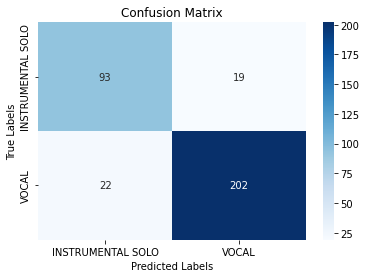

In [17]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (notes, notes_len)), _ in test_loader:           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())

            output = np.argmax(output.cpu().detach(), axis=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['INSTRUMENTAL SOLO', 'VOCAL'])
    ax.yaxis.set_ticklabels(['INSTRUMENTAL SOLO', 'VOCAL'])
    
    
best_model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [14]:
from torchviz import make_dot
import hiddenlayer as hl

ModuleNotFoundError: No module named 'torchviz'

In [ ]:
next(iter(test_iter)).notes

In [ ]:
def print_architecture(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    for (labels, (notes, notes_len)), _ in test_loader:           
        labels = labels.to(device)
        notes = notes.to(device)
        notes_len = notes_len.cpu()
        output = model(notes.long(), notes_len.long())
        
        
        transforms = [# hl.transforms.Prune('Constant'),
                      #hl.transforms.FoldDuplicates()
                     ] # Removes Constant nodes from graph.

        graph = hl.build_graph(model, (notes,notes_len), transforms=transforms)
        graph.theme = hl.graph.THEMES['blue'].copy()
        print(graph)
        graph.save('rnn_hiddenlayer', format='png')

        #output = (output > threshold).int()
        #y_pred.extend(output.tolist())
        #y_true.extend(labels.tolist())
        #print(dict(model.named_parameters()))
        #make_dot(output,params=dict(model.named_parameters())).render()
        break

    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
print_architecture(best_model, test_iter)

In [ ]:
# print(best_model)